In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import ast
import itertools
from scipy.sparse import hstack
import matplotlib.pyplot as plt

# Loading the Data

In [4]:
root = 'archive/'

In [5]:
interactions_test = pd.read_csv(f'{root}interactions_test.csv')
interactions_train = pd.read_csv(f'{root}interactions_train.csv')
interactions_validation = pd.read_csv(f'{root}interactions_validation.csv')
PP_recipes = pd.read_csv(f'{root}PP_recipes.csv').set_index('i').sort_index()
PP_users = pd.read_csv(f'{root}PP_users.csv').set_index('u').sort_index()
RAW_interactions = pd.read_csv(f'{root}RAW_interactions.csv')
RAW_recipes = pd.read_csv(f'{root}RAW_recipes.csv')

# Data Cleaning

Checking the dataset to ensure all the datatypes were correct, we found an issue within the columns meant to contain lists. They were improperly loaded in as strings instead of lists and need to be converted into lists.

The ast import and its function literal_eval() was applied to the column to convert string representations of lists to proper lists

The following columns in PP_recipes had their values stored as strings instead of lists:
- 'name_tokens'
- 'ingredient_tokens'
- 'steps_tokens'
- 'techniques'
- 'ingredient_ids'

The same was found for the following columns in PP_users:
- 'techniques'
- 'items'
- 'ratings'

In addition to adjusting the data types for those columns, we also want to include two columns as features that were not already found in the preprocessed data. For the PP_recipes dataset, we want to add the following columns:
- 'n_reviewers': the number of people who reviewed the recipe 
- 'n_steps': the number of steps it takes to complete the recipe

These two additional columns will help us check whether popularity, as measured by the number of reviews a recipe has, or the difficulty of completing a recipe, as measured by the number of steps it requires, has an impact on the user rating for a recipe

In [6]:
PP_recipes.dtypes

id                    int64
name_tokens          object
ingredient_tokens    object
steps_tokens         object
techniques           object
calorie_level         int64
ingredient_ids       object
dtype: object

In [7]:
recipe_review_counts = RAW_interactions.groupby('recipe_id')['rating'].count()

PP_recipes['n_reviewers'] = PP_recipes['id'].apply(lambda x: recipe_review_counts[x])
PP_recipes['n_steps'] = PP_recipes.merge(RAW_recipes, on='id', how='left')['n_steps']
PP_recipes['name_tokens'] = PP_recipes['name_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_tokens'] = PP_recipes['ingredient_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['steps_tokens'] = PP_recipes['steps_tokens'].apply(lambda x: ast.literal_eval(x))
PP_recipes['techniques'] = PP_recipes['techniques'].apply(lambda x: ast.literal_eval(x))
PP_recipes['ingredient_ids'] = PP_recipes['ingredient_ids'].apply(lambda x: ast.literal_eval(x))

PP_recipes.head()

,id,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_reviewers,n_steps
i,,,,,,,,,
0,40893,"[40480, 1454, 16201, 2056, 955, 541, 11332, 82...","[[1424, 8876, 11007], [3484, 21453], [38966, 2...","[40480, 40482, 23667, 11007, 240, 21453, 240, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0,"[3384, 7979, 2127, 3502, 3217, 1257, 2778, 500...",2,4
1,44394,"[40480, 34712, 22683, 11274, 5409, 29868, 40481]","[[5343, 535, 2044, 5409, 7087], [17869, 6020],...","[40480, 40482, 12172, 1281, 5409, 7087, 240, 6...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[912, 7557, 2499, 5382]",1,5
2,85009,"[40480, 12187, 13995, 571, 14719, 40481]","[[1061, 494, 813, 2141], [31843], [30645, 4785...","[40480, 40482, 2572, 19472, 31757, 512, 823, 4...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",2,"[4623, 6265, 1168, 6016, 3597, 3440, 7213, 169...",2,3
3,134728,"[40480, 27, 12, 263, 4017, 1494, 273, 14122, 4...","[[5867, 34056], [17918], [15022, 8361], [6953]...","[40480, 40482, 7087, 17918, 240, 6953, 488, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[1304, 2683, 3217, 6270, 3532, 869, 7557, 3698...",7,10
4,200236,"[40480, 16212, 11880, 556, 19811, 12772, 22075...","[[16212, 1535], [6953], [1430, 1301, 11332], [...","[40480, 40482, 2525, 10906, 485, 29848, 40478,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2,"[4130, 6270, 3486, 7557, 5010, 3203, 2683, 125...",4,14


In [8]:
PP_users['techniques'] = PP_users['techniques'].apply(lambda x: ast.literal_eval(x))
PP_users['items'] = PP_users['items'].apply(lambda x: ast.literal_eval(x))
PP_users['ratings'] = PP_users['ratings'].apply(lambda x: ast.literal_eval(x))

PP_users.head()

,techniques,items,n_items,ratings,n_ratings
u,,,,,
0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


# EDA Graphs

In [9]:
recipes_interactions_merged = interactions_train.merge(PP_recipes, left_on='recipe_id', right_index=True, how='left')
users_interactions_merged = interactions_train.merge(PP_users, left_on='recipe_id', right_index=True, how='left')
avg_ratings_per_recipe = recipes_interactions_merged.groupby('recipe_id')['rating'].mean()
avg_ratings_per_user = users_interactions_merged.groupby('user_id')['rating'].mean()

It is clear that the dataset is severely left-skewed, with a large majority of the ratings being a score of 5. This may cause the correlation between the independent variables and the user rating to be much more unclear and may mean that our final model could perform only slightly better than a baseline that simply predicts the mean value.

The additional graphs showing the relation between rating and individual features do not show a visibly clear pattern.

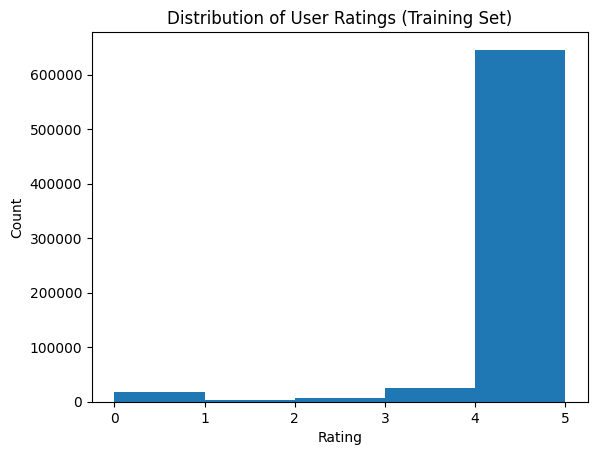

In [10]:
plt.hist(interactions_train['rating'], bins=5)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of User Ratings (Training Set)')
plt.show()

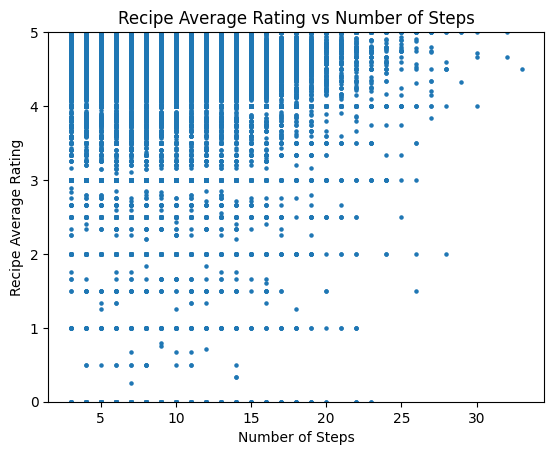

In [11]:
steps_per_recipe = recipes_interactions_merged.groupby('recipe_id')['n_steps'].first()

plt.scatter(steps_per_recipe, avg_ratings_per_recipe, s=5)
plt.xlabel('Number of Steps')
plt.ylabel('Recipe Average Rating')
plt.ylim(0,5)
plt.title('Recipe Average Rating vs Number of Steps')
plt.show()

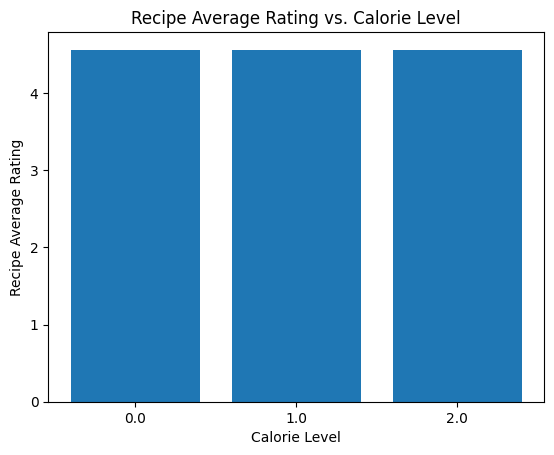

In [12]:
calorie_level_per_recipe = recipes_interactions_merged.groupby('calorie_level')['rating'].mean()

plt.bar(x=calorie_level_per_recipe.index.astype(str), height=calorie_level_per_recipe)
plt.xlabel('Calorie Level')
plt.ylabel('Recipe Average Rating')
plt.title('Recipe Average Rating vs. Calorie Level');

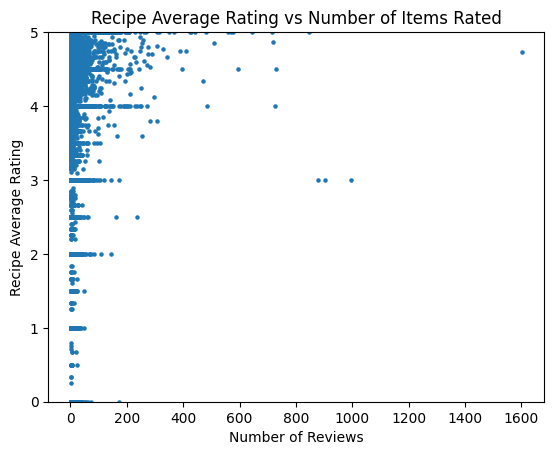

In [13]:
reviews_per_recipe = recipes_interactions_merged.groupby('recipe_id')['n_reviewers'].first()

plt.scatter(reviews_per_recipe, avg_ratings_per_recipe, s=5)
plt.xlabel('Number of Reviews')
plt.ylabel('Recipe Average Rating')
plt.ylim(0,5)
plt.title('Recipe Average Rating vs Number of Items Rated');

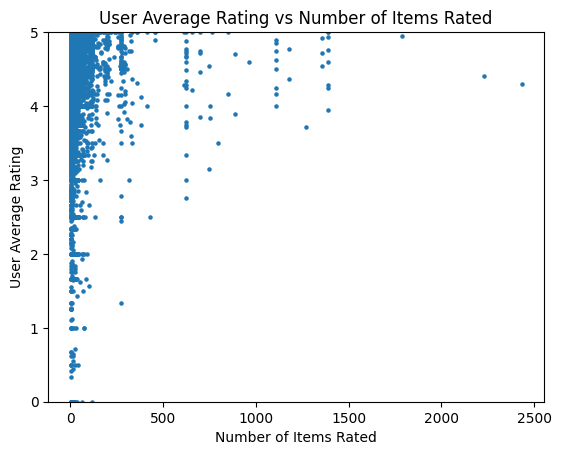

In [14]:
items_per_user = users_interactions_merged.groupby('user_id')['n_items'].first()

plt.scatter(items_per_user, avg_ratings_per_user, s=5)
plt.xlabel('Number of Items Rated')
plt.ylabel('User Average Rating')
plt.ylim(0,5)
plt.title('User Average Rating vs Number of Items Rated');

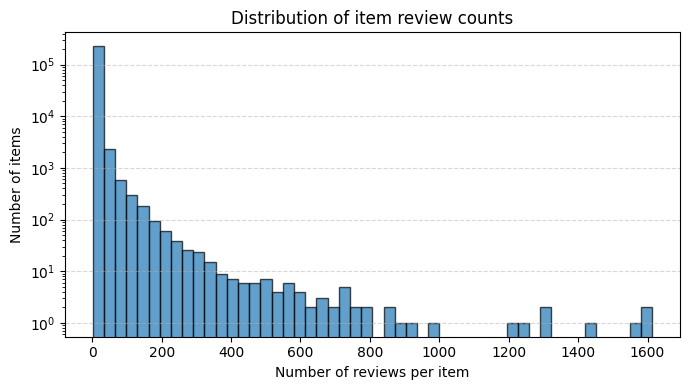

In [15]:
item_counts = RAW_interactions.groupby('recipe_id').size()

plt.figure(figsize=(7,4))
plt.hist(item_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of reviews per item")
plt.ylabel("Number of items")
plt.title("Distribution of item review counts")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.yscale("log") 
plt.tight_layout()
plt.show()

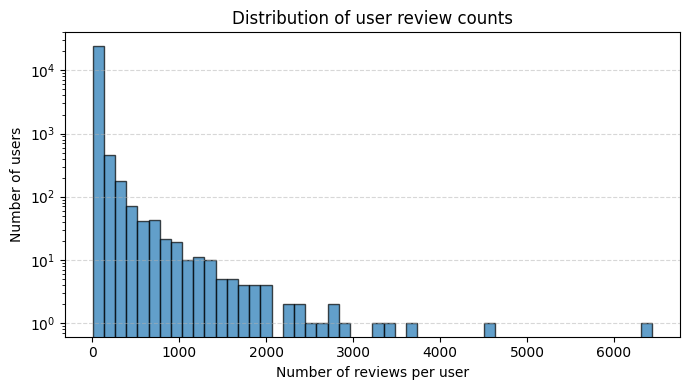

In [16]:
user_counts = PP_users['n_ratings']  # or RAW_interactions.groupby('user_id').size()

plt.figure(figsize=(7,4))
plt.hist(user_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Number of reviews per user")
plt.ylabel("Number of users")
plt.title("Distribution of user review counts")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.yscale("log")  # optional if tail is heavy
plt.tight_layout()
plt.show()

We also do EDA on the text data by observing the TF-IDF of each rating grade

In [17]:
texts = RAW_interactions[['rating', 'review']].dropna()

grouped = texts.groupby('rating')['review'].apply(lambda x: ' '.join(x.astype(str)))
docs = grouped.tolist()
ratings = grouped.index.tolist()

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
tfidf = vec.fit_transform(docs) # shape: (n_ratings, vocab_size)

feature_names = np.array(vec.get_feature_names_out())
top_k = 100
top_terms = {}
for i, r in enumerate(ratings):
    row = tfidf[i].toarray().ravel()
    top_idx = row.argsort()[::-1][:top_k]
    top_terms[r] = list(zip(feature_names[top_idx], row[top_idx]))

count={}
for rate in top_terms:
    for word in top_terms[rate]:
        if word[0] not in count:
            count[word[0]] = 0
        count[word[0]] += 1

for rate in top_terms:
    new_words = []
    for word in top_terms[rate]:
        if count[word[0]] < 2:
            new_words.append(word)
    top_terms[rate] = new_words

for rate in top_terms:
    print(f"{rate}: {top_terms[rate]}")

0: [('going', np.float64(0.041391948842409355)), ('years', np.float64(0.0353371179852758)), ('want', np.float64(0.030881117770123718)), ('brown', np.float64(0.030762685870717683)), ('gt', np.float64(0.03048141010962835)), ('lt', np.float64(0.030436998147351086)), ('food', np.float64(0.030333370235370805))]
1: [('waste', np.float64(0.04890576408689602)), ('directions', np.float64(0.04406041097392746)), ('awful', np.float64(0.03798756840567353)), ('batter', np.float64(0.034240495331644506)), ('terrible', np.float64(0.034175890623471594)), ('horrible', np.float64(0.03340063412539662)), ('recipe exactly', np.float64(0.03314221529270497)), ('tasted like', np.float64(0.0314624928802092)), ('couldn', np.float64(0.031139469339344625)), ('away', np.float64(0.030041189300405086)), ('got', np.float64(0.030041189300405086)), ('powder', np.float64(0.029718165759540515))]
2: [('care', np.float64(0.04235092815530831)), ('just didn', np.float64(0.03879068701803647))]
3: [('needed', np.float64(0.037844

# Creating Train, Validation, Test Variables

In [19]:
train_X = interactions_train.drop(columns=['rating'])
train_y = interactions_train['rating']
validation_X = interactions_validation.drop(columns=['rating'])
validation_y = interactions_validation['rating']
test_X = interactions_test.drop(columns=['rating'])
test_y = interactions_test['rating']

# Creating and Testing Baseline Models

We are using 4 baseline models for comparison.

Baseline 1 predicts the global mean for every recipe

Baseline 2 predicts the user's average rating on recipes if the user is found in the training set or the global mean if the user cannot be found

Baseline 3 predicts the recipe's average rating given by users if the recipe is found in the training set or the global mean if the recipe cannot be found

Baseline 4 predicts the user's rating on a recipe based on the calorie level of the recipe and the number of recipes the user has previously reviewed 
- Reccomender systems typically utilize data from both the recipe and the user to make predictions, so we thought a helpful baseline would be to see the results for a regression model that makes predictions using only one feature from the user side and one feature from the recipe side.

For all the models, we were extra careful to not leak any data from the test set, which would invalidate the results, and only used the training set to compute values or teach models.

In [184]:
def MSE(predictions, y):
    diffs = [(a-b)**2 for (a,b) in zip(predictions, y)]
    return sum(diffs)/len(diffs)

In [20]:
#Baseline 1
global_average = interactions_train['rating'].mean()
baseline1_preds = [global_average] * test_y.shape[0]

print('Mean Squared Error for Baseline 1 (Always Predict Global Average):', MSE(baseline1_preds, test_y))

Mean Squared Error for Baseline 1 (Always Predict Global Average): 1.921769558034767


In [21]:
#Baseline 2
user_means = interactions_train.groupby('u')['rating'].mean()
baseline2_preds = [np.mean(user_means.loc[u]) if u in user_means.index else global_average for u in interactions_test['u']]

print('Mean Squared Error for Baseline 2 (Always Predict User Average):', MSE(baseline2_preds, test_y))

Mean Squared Error for Baseline 2 (Always Predict User Average): 1.8334151093136715


In [22]:
#Baseline 3
recipe_means = interactions_train.groupby('i')['rating'].mean()
baseline3_preds = [np.mean(recipe_means.loc[i]) if i in recipe_means.index else global_average for i in interactions_test['i']]

print('Mean Squared Error for Baseline 3 (Always Predict Recipe Average):', MSE(baseline3_preds, test_y))

Mean Squared Error for Baseline 3 (Always Predict Recipe Average): 1.921769558034767


In [23]:
#Baseline 4
baseline_train_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in train_X[['u', 'i']].to_numpy()]
baseline_test_X_features = [[PP_recipes.iloc[i]['calorie_level'], PP_users.iloc[u]['n_items']] for u, i in test_X[['u', 'i']].to_numpy()]

baseline_model = LinearRegression()
baseline_model.fit(baseline_train_X_features, train_y)
baseline_model_preds = baseline_model.predict(baseline_test_X_features)

print('Mean Squared Error for Baseline 4 (Regression With Two Predictors):', MSE(baseline_model_preds, test_y))

Mean Squared Error for Baseline 4 (Regression With Two Predictors): 1.889391224000372


# Building Final Model

In [24]:
user_stats = interactions_train.groupby('u')['rating'].agg(['mean', 'count'])
item_stats = interactions_train.groupby('i')['rating'].agg(['mean', 'count'])
reg = 10  # shrinkage to avoid huge biases for low counts

user_bias = ((user_stats['mean'] - global_average) * user_stats['count'] / (user_stats['count'] + reg)).to_dict()
item_bias = ((item_stats['mean'] - global_average) * item_stats['count'] / (item_stats['count'] + reg)).to_dict()

recipe_sets = {
    'ingredient_ids': [set(x) for x in PP_recipes['ingredient_ids']],
    'steps_tokens':   [set(x) for x in PP_recipes['steps_tokens']],
}

max_date = pd.to_datetime(interactions_train['date']).max()
user_avg_calorie = {
    u: float(np.mean([PP_recipes.iloc[i]['calorie_level'] for i in items])) if len(items) else 0.0
    for u, items in zip(PP_users.index, PP_users['items'])
}
user_avg_steps = {
    u: float(np.mean([PP_recipes.iloc[i]['n_steps'] for i in items])) if len(items) else 0.0
    for u, items in zip(PP_users.index, PP_users['items'])
}

user_log_n = np.log1p(PP_users['n_ratings'])
recipe_log_n = np.log1p(PP_recipes['n_reviewers'])

user_bins = pd.qcut(user_log_n, q=5, labels=False, duplicates="drop")  # 0..4
recipe_bins = pd.qcut(recipe_log_n, q=5, labels=False, duplicates="drop")

PP_users['logn_bin'] = user_bins
PP_recipes['logn_bin'] = recipe_bins

rating_freq = interactions_train['rating'].value_counts()
inv_freq = 1.0 / rating_freq
sample_weight = interactions_train['rating'].map(inv_freq).to_numpy()

user_items = PP_users['items']  # alias
TOP_K = 5
K_CAP = 30
rng = np.random.default_rng(42)


In [25]:
def one_hot_bin(bin_val, n_bins=5):
    arr = np.zeros(n_bins, dtype=float)
    if bin_val == bin_val:  # not NaN
        arr[int(bin_val)] = 1.0
    return arr

In [26]:
def familiarity(datum, col, use_max=False):
    u = datum['u']
    r = datum['i']
    target = recipe_sets[col][r]
    items = user_items.iloc[u]
    if len(items) > K_CAP:
        items = rng.choice(items, size=K_CAP, replace=False)
    sims = []
    for rid in items:
        known = recipe_sets[col][rid]
        inter = len(target & known)
        union = len(target) + len(known) - inter
        sims.append(inter / union if union else 0.0)
    if not sims:
        return 0.0
    sims = sorted(sims, reverse=True)[:TOP_K]
    return max(sims) if use_max else float(np.mean(sims))


In [27]:
def safe_mean(vals):
    return float(np.mean(vals)) if len(vals) else 0.0

In [28]:
def feature(datum):
    u = datum['u']
    r = datum['i']
    ub = user_bias.get(u, 0.0)
    ib = item_bias.get(r, 0.0)
    calorie_level = PP_recipes.iloc[r]['calorie_level']
    n_steps = PP_recipes.iloc[r]['n_steps']
    cal_delta = calorie_level - user_avg_calorie.get(u, 0.0)
    steps_delta = n_steps - user_avg_steps.get(u, 0.0)
    recency_days = (max_date - pd.to_datetime(datum['date'])).days
    ingredient_fam = familiarity(datum, 'ingredient_ids')
    steps_fam = familiarity(datum, 'steps_tokens')
    recipe_tech = np.array(PP_recipes.iloc[r]['techniques'])
    denom = recipe_tech.sum()
    technique_overlap = ((np.array(PP_users.iloc[u]['techniques']) * recipe_tech).sum() / denom) if denom else 0.0
    user_bin_oh = one_hot_bin(PP_users.iloc[u]['logn_bin'])
    recipe_bin_oh = one_hot_bin(PP_recipes.iloc[r]['logn_bin'])
    return [
        ub, ib,
        calorie_level, n_steps,
        cal_delta, steps_delta,
        recency_days,
        ingredient_fam, steps_fam,
        technique_overlap,
        *user_bin_oh,
        *recipe_bin_oh,
    ]

In [29]:
#TF-IDF
texts = RAW_interactions[['rating', 'review']].dropna()
grouped = texts.groupby('rating')['review'].apply(lambda x: ' '.join(x.astype(str)))
docs = grouped.tolist()
ratings = grouped.index.tolist()

vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
tfidf = vec.fit_transform(docs)
vocab = np.array(vec.get_feature_names_out())

def remove_tfidf_outliers(mat, whisker=1.5):
    arr = mat.toarray()
    for i in range(arr.shape[0]):
        row = arr[i]
        nz = row[row > 0]
        if nz.size == 0:
            continue
        q1, q3 = np.percentile(nz, [25, 75])
        cutoff = q3 + whisker * (q3 - q1)
        row[row > cutoff] = 0.0
        arr[i] = row
    return arr

tfidf_clean = remove_tfidf_outliers(tfidf, whisker=1.5)

# build unique top-k vocab per rating
top_k = 10
term_counts = {}
top_terms = {}
for i, r in enumerate(ratings):
    row = tfidf_clean[i]
    idx = row.argsort()[::-1][:top_k * 3]  # grab extra in case of overlaps
    terms = [(vocab[j], row[j]) for j in idx if row[j] > 0]
    top_terms[r] = terms
    for t, _ in terms:
        term_counts[t] = term_counts.get(t, 0) + 1

clean_vocab_terms = []
for r, terms in top_terms.items():
    picked = []
    for t, s in terms:
        if term_counts[t] == 1:
            picked.append((t, s))
        if len(picked) == top_k:
            break
    clean_vocab_terms.extend([t for t, _ in picked])

clean_vocab = {t: i for i, t in enumerate(sorted(set(clean_vocab_terms)))}

In [30]:
len(train_X), len(validation_X), len(test_X)

(698901, 7023, 12455)

In [31]:
# add review text to splits by user_id/recipe_id
key_cols = ["user_id", "recipe_id"]

raw_reviews = RAW_interactions[key_cols + ["review"]]

interactions_train = interactions_train.merge(raw_reviews, on=key_cols, how="left")
interactions_validation = interactions_validation.merge(raw_reviews, on=key_cols, how="left")
interactions_test = interactions_test.merge(raw_reviews, on=key_cols, how="left")

In [32]:
FILTER_ITEM = False
FILTER_USER = True
# keep only training items (recipes) that have at least two reviews
if FILTER_ITEM:
    item_counts = interactions_train.groupby('recipe_id').size()
    keep_items = item_counts[item_counts >= 2].index
    interactions_train = interactions_train[interactions_train['recipe_id'].isin(keep_items)].reset_index(drop=True)

# keep only training users who have left at least two reviews
if FILTER_USER:
    user_counts = interactions_train.groupby('user_id').size()
    keep_users = user_counts[user_counts >= 2].index
    interactions_train = interactions_train[interactions_train['user_id'].isin(keep_users)].reset_index(drop=True)

train_X = interactions_train.drop(columns=['rating'])
train_y = interactions_train['rating']

In [33]:
# Build numerical features
numeric_train = np.vstack(train_X.apply(feature, axis=1))
numeric_val   = np.vstack(validation_X.apply(feature, axis=1))
numeric_test  = np.vstack(test_X.apply(feature, axis=1))

In [34]:
#Build vocab feature
vec_clean = TfidfVectorizer(vocabulary=clean_vocab)
tfidf_train = vec_clean.fit_transform(interactions_train['review'].fillna(''))
tfidf_val   = vec_clean.transform(interactions_validation['review'].fillna(''))
tfidf_test  = vec_clean.transform(interactions_test['review'].fillna(''))

In [35]:
# combine numeric + tfidf (sparse)
train_features = hstack([numeric_train, tfidf_train])
val_features   = hstack([numeric_val, tfidf_val])
test_features  = hstack([numeric_test, tfidf_test])

In [36]:
#Change the feature vectors to csr
train_features = train_features.tocsr()
val_features   = val_features.tocsr()
test_features  = test_features.tocsr()

In [37]:
#Linear Model
lin_model = LinearRegression()
lin_model.fit(train_features, train_y)
val_preds = lin_model.predict(val_features)
test_preds = lin_model.predict(test_features)
print("Val MSE:", MSE(val_preds, validation_y))

Val MSE: 1.5523440023659114


In [38]:
#Ridge Model
alpha_vals = [0.00000000001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000000000]

best_mse = np.inf
best_ridge_model = best_alpha = None

for a in alpha_vals:
    ridge = Ridge(alpha = a)
    ridge.fit(train_features, train_y)
    val_preds = ridge.predict(val_features)
    curr_mse = MSE(val_preds, validation_y)
    
    print(f"Validation MSE (Alpha={a}): {curr_mse}")

    if curr_mse < best_mse:
        best_mse = curr_mse
        best_ridge_model = ridge
        best_alpha = a

print("Best Alpha Value:", best_alpha)
print('Best Val MSE:', best_mse)

Validation MSE (Alpha=1e-11): 1.5677217355981972
Validation MSE (Alpha=0.0001): 1.5677217620739579
Validation MSE (Alpha=0.001): 1.5677217638325078
Validation MSE (Alpha=0.01): 1.5677218640501414
Validation MSE (Alpha=0.1): 1.5677217883651113
Validation MSE (Alpha=1): 1.567721595948022
Validation MSE (Alpha=10): 1.567720031499649
Validation MSE (Alpha=100): 1.5677053729706014
Validation MSE (Alpha=1000): 1.567648023393857
Validation MSE (Alpha=10000000000): 1.796424194412477
Best Alpha Value: 1000
Best Val MSE: 1.567648023393857


# Final Model

The linear regression model returned a better validation MSE, so that will be our final model

In [44]:
best_model = LinearRegression()
best_model.fit(train_features, train_y)
test_preds = best_model.predict(test_features)

print("Test MSE:", MSE(test_preds, test_y))

Test MSE: 1.6610087348308993


# Sainty Check

In [ ]:
# Bounds
LOW, HIGH = 1, 5

# Validation predictions
val_preds = best_model.predict(val_features)

print("VAL predictions outside range:",
      np.sum((val_preds < LOW) | (val_preds > HIGH)))

# Clip predictions to valid range (recommended for ratings)
val_preds_clipped = np.clip(val_preds, LOW, HIGH)


VAL predictions outside range: 6


In [41]:
test_preds = best_model.predict(test_features)
print("TEST predictions outside range:",
      np.sum((test_preds < LOW) | (test_preds > HIGH)))

test_preds_clipped = np.clip(test_preds, LOW, HIGH)


TEST predictions outside range: 11


In [ ]:

coefs = best_model.coef_
numeric_feature_names = [
    'user_bias',
    'item_bias',
    'calorie_level',
    'n_steps',
    'cal_delta',
    'steps_delta',
    'recency_days',
    'ingredient_familiarity',
    'steps_familiarity',
    'technique_overlap',
    'user_bin_0',
    'user_bin_1',
    'user_bin_2',
    'user_bin_3',
    'user_bin_4',
    'recipe_bin_0',
    'recipe_bin_1',
    'recipe_bin_2',
    'recipe_bin_3',
    'recipe_bin_4',
]

tfidf_feature_names = vec_clean.get_feature_names_out()
top_10_idx = np.argsort(np.abs(coefs))[-10:][::-1]

print("=" * 80)
print("TOP 10 MOST IMPACTFUL FEATURES (by absolute weight)")
print("=" * 80)
for rank, idx in enumerate(top_10_idx, 1):
    if idx < len(numeric_feature_names):
        name = numeric_feature_names[idx]
    else:
        name = f"TF-IDF: {tfidf_feature_names[idx - len(numeric_feature_names)]}"
    
    coef = coefs[idx]
    direction = "↑ increases rating" if coef > 0 else "↓ decreases rating"
    print(f"{rank}. {name:50s} Weight: {coef:8.4f} ({direction})")
print("=" * 80)


TOP 10 MOST IMPACTFUL FEATURES (by absolute weight)
1. item_bias                                          Weight:   2.2323 (↑ increases rating)
2. user_bias                                          Weight:   1.0818 (↑ increases rating)
3. TF-IDF: turn                                       Weight:  -0.3520 (↓ decreases rating)
4. TF-IDF: potential                                  Weight:  -0.2401 (↓ decreases rating)
5. TF-IDF: overpowered                                Weight:  -0.2290 (↓ decreases rating)
6. TF-IDF: excited                                    Weight:  -0.2041 (↓ decreases rating)
7. TF-IDF: sooo                                       Weight:   0.1723 (↑ increases rating)
8. TF-IDF: supposed                                   Weight:  -0.1705 (↓ decreases rating)
9. TF-IDF: luck                                       Weight:  -0.1645 (↓ decreases rating)
10. TF-IDF: loves                                      Weight:   0.1526 (↑ increases rating)


In [42]:
# Evaluate clipped predictions
test_mse_clipped = MSE(test_preds_clipped, test_y)
val_mse_clipped = MSE(val_preds_clipped, validation_y)

print("Test MSE (clipped):", test_mse_clipped)
print("Val MSE (clipped):", val_mse_clipped)

Test MSE (clipped): 1.6611589218038254
Val MSE (clipped): 1.5526208369150036
